# Self-Driving Car Engineer Nanodegree

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. 

Sections that begin with <b>'Implementation'</b> in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with <b>'Optional'</b> in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a <b>'Question'</b> header. Carefully read each question and provide thorough answers in the following text boxes that begin with <b>'Answer'</b>. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

> <b>Note:</b> Code and Markdown cells can be executed using the <b>Shift + Enter</b> keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## 1. Load the data

In [1]:
# Mount Google Drive to get the dataset
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# import modules
import pickle
import numpy as np

# define the location of datasets
training_file = '/content/gdrive/My Drive/Datasets/Traffic_Sign/train.p'
testing_file = '/content/gdrive/My Drive/Datasets/Traffic_Sign/test.p'

# open the datasets
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
# take the features and the labels for train and test    
x_train, y_train = train['features'], train['labels']
x_test, y_test = test['features'], test['labels']

print('Done step 1.')

Mounted at /content/gdrive
Done step 1.


## 2. Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

* <b>features</b> is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels);
* <b>labels</b> is a 2D array containing the label/class id of the traffic sign. The file signnames.csv contains id -> name mappings for each id;
* <b>sizes</b> is a list containing tuples, (width, height) representing the the original width and height the image;
* <b>coords</b> is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. <b> THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES. </b>

In [2]:
# import modules
import numpy as np

# number of training examples
n_train = len(y_train)

# number of testing examples.
n_test = len(y_test)

# the shape of an traffic sign image
image_shape = x_train.shape

# number of unique classes/labels there are in the dataset
n_classes = len(np.unique(np.append(y_train,y_test)))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (39209, 32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

11


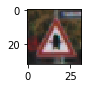

In [3]:
# import modules

import matplotlib.pyplot as plt
import random
import numpy as np

# to visualize the results in the notebook
%matplotlib inline

index = random.randint(0,len(x_train))
image = x_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])

Text(0.5, 1.0, 'histogram before data preprocessing')

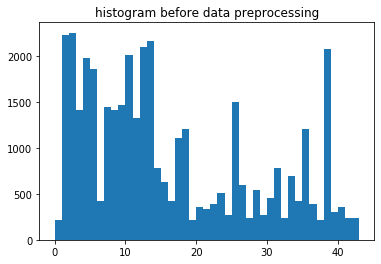

In [4]:
# visulization of the histogram (number of images per class)

images_per_class, bins, _ = plt.hist(y_train,bins=range(n_classes+1))
plt.title('histogram before data preprocessing')

## 3. Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

* Neural network architecture;
* Play around preprocessing techniques (normalization, rgb to grayscale, etc);
* Number of examples per label (some have more than others);
* Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

In [5]:
# import modules
import cv2

# 1. rgb to grayscale 
# 2. apply histogram equalization
# 3. normalize the training and testing data to [-1 1]

def grayAndEqualizeHist(img):
    """
        :param img: input RGB image
        :return: histogram equalized grayscale image
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
    equHist  = cv2.equalizeHist(gray)
    return equHist

# take each image and apply the transformation function to it
x_train = np.array([grayAndEqualizeHist(img) for img in x_train])
x_test = np.array([grayAndEqualizeHist(img) for img in x_test])

print('Done step 3.')

Done step 3.


#### Question 1
<i>Describe how you preprocessed the data. Why did you choose that technique?</i>

<b>Answer:</b>

1. <b>Converting RGB to grayscale</b>

After testing both RGB and grayscale versions with LeNet, I found that the accuracy for testing data is about the same: 87% (RGB) and 88% (Grayscale). But, by using the grayscale image the number of parameters in the model are significantly reduced. One possible advantage of using grayscale image is that it may be more robust than RGB images regarding to light/color changes.

2. <b>Normalize the images</b>

The grayscale image is [0 255], and after normalization it becomes [-1 1].

#### Generate more images with a random similarity transform (2x3 matrix)

Visulization of one image: before and after similarity transform


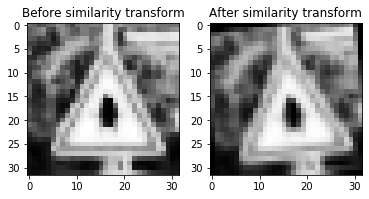

In [6]:
# import modules
import random
import math
import cv2

def applyRandSimilarityTran(image, n):
    """ 
        apply random similarity transformation to the image, and return
        n transformed images
    """
    output_images = np.zeros((n,32,32))

    for i in range(n):
        # rotation
        angle = random.uniform(-15, 15) 

        # scale
        s = random.uniform(0.7, 1.3)   

        rows, cols = image.shape[0:2]
        image_center = (rows/2.0, cols/2.0)
        rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1)
        M_rot = np.vstack([rot_mat,[0,0,1]])

        # translation along x axis
        tx = random.uniform(-2, 2)  
        
        # translation along y axis
        ty = random.uniform(-2, 2)      
        
        M_tran = np.float32([[1,0,tx],[0,1,ty],[0,0,1]])

        M = np.matrix(M_tran) * np.matrix(M_rot)

        # similarity transformation
        M = np.float32(M[:2][:]) 

        tmp = cv2.warpAffine(image, M, (cols, rows))    
        output_images[i][:][:] = tmp
        
    return output_images

# visualize the similarity transformation for one image
image = x_train[index].squeeze()
plt.figure
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title('Before similarity transform')

new_image = applyRandSimilarityTran(image, 1)
plt.subplot(1,2,2)
plt.imshow(new_image[0][:][:], cmap='gray')
plt.title('After similarity transform')
    
print('Visulization of one image: before and after similarity transform')

In [7]:
# generate additional data
print('Generating 5 times more additional data.')    
n = 5
x_added = np.vstack([applyRandSimilarityTran(im,n) for im in x_train])
y_added = np.repeat(y_train, n)

# append the generated data to the training data
x_train = np.append(x_train, x_added, axis=0)
x_train = x_train[...,np.newaxis]
y_train = np.append(y_train, y_added, axis=0)


x_test = x_test[...,np.newaxis]
print('Generated data are added into training data.')

Generating 5 times more additional data.
Generated data are added into training data.


In [8]:
from sklearn.model_selection import train_test_split

x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# number of training examples
n_train = len(y_train)

# number of validation examples
n_validation = len(y_validation)

# number of testing examples
n_test = len(y_test)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)

Number of training examples = 188203
Number of validation examples = 47051
Number of testing examples = 12630


#### Question 2
<i>Describe how you set up the training, validation and testing data for your model. 
    
<b>Optional:</b> If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?</i>

<b>Answer:</b>

I generate 5 times more extra training data from the original training data. I apply the 5 random similarity transforms to each of training images and return 5 extra generated training images. In order to generate the similarity transform, I apply random <i>rotation angle</i> from (-15, 15) degress, random <i>scale</i> from [0.9, 1.1], and <i>random translations</i> tx and ty from [-2,2]. Therefore, the generated images are only a little bit different from the original training images, so that we could make sure the generated data are meaningful data for the network to learn.

Why to generate extra images for every class? I found that sometime people would generate extra images only for the minority classes, which has significant less samples than other classes. But for this use case, I found that generate extra dataset for each image outperforms than only generate extra data for the minority classes. One possible explanation is that in real life, there are some traffic signs are much more frequent than others, e.g. “you might see much more speed limit signs than roundabout sign in the highway.”

Why to generate the data? In my experiments, I found that this step is crucial! I try the LeNet (for grayscale image) with the original dataset, and the accuracy for the testing data is 87%. However, once I upscale the training data by generating 5 times more dataset, and I found that, without any modification of the network, the accuracy immediately becomes 93.7% for the testing dataset.

In [9]:
# define the architecture
# import modules
import tensorflow as tf
from tensorflow.contrib.layers import flatten
#from tensorflow.python.compiler.layers import flatten
#from tensorflow.python.compiler import *
tf.__version__

'1.15.0'

#### In LeNet(x) function: I use the architecture like the figure in below, and apply dropout for before the last layer:
![LeNet](images/lenet.png)

In [0]:
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer.
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma), name="conv1_W")
    conv1_b = tf.Variable(tf.zeros(6),name="conv1_b")
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma),name="conv2_W")
    conv2_b = tf.Variable(tf.zeros(16),name="conv2_b")
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma), name="fc1_W")
    fc1_b = tf.Variable(tf.zeros(120),name="fc1_b")
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma),name="fc2_W")
    fc2_b  = tf.Variable(tf.zeros(84),name="fc2_b")
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Dropout.
    hidden_layer = tf.nn.dropout(fc2, keep_prob)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma),name="fc3_W")
    fc3_b  = tf.Variable(tf.zeros(n_classes),name="fc3_b")
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

#### In ConvNet(x) function: I use the architecture like the figure in below, and apply dropout for before the last layer:
![ConvNet](images/convnet.png)

In [0]:
def ConvNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma), name="W1")
    x = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID')
    b1 = tf.Variable(tf.zeros(6), name="b1")
    x = tf.nn.bias_add(x, b1)

    # Activation.
    x = tf.nn.relu(x)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer1 = x
    
    # Layer 2: Convolutional. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma), name="W2")
    x = tf.nn.conv2d(x, W2, strides=[1, 1, 1, 1], padding='VALID')
    b2 = tf.Variable(tf.zeros(16), name="b2")
    x = tf.nn.bias_add(x, b2)
                     
    # Activation.
    x = tf.nn.relu(x)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 3: Convolutional. Output = 1x1x400.
    W3 = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean = mu, stddev = sigma), name="W3")
    x = tf.nn.conv2d(x, W3, strides=[1, 1, 1, 1], padding='VALID')
    b3 = tf.Variable(tf.zeros(400), name="b3")
    x = tf.nn.bias_add(x, b3)
                     
    # Activation.
    x = tf.nn.relu(x)

    # Flatten. Input = 14x14x6. Output = 1176.
    layer1flat = flatten(layer1)
    
    # Flatten x. Input = 1x1x400. Output = 400.
    xflat = flatten(x)
    
    # Concat layer1flat and x. Input = 1176 + 400. Output = 1576.
    x = tf.concat([xflat, layer1flat], 1)
    
    # Dropout.
    x = tf.nn.dropout(x, keep_prob)
    
    # Layer 4: Fully Connected. Input = 1576. Output = 43.
    W4 = tf.Variable(tf.truncated_normal(shape=(1576, 43), mean = mu, stddev = sigma), name="W4")
    b4 = tf.Variable(tf.zeros(43), name="b4")    
    logits = tf.add(tf.matmul(x, W4), b4)
    
    return logits

#### Question 3
<i>What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)</i>

In [12]:
# train the model
# import modules
from sklearn.utils import shuffle

with tf.Session() as sess:
    devices = sess.list_devices()
    print(devices)
    
rate = 0.001
EPOCHS = 25
BATCH_SIZE = 128
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

logits = ConvNet(x)
#logits = LeNet(x)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

print('Architecture is defined.')

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 12946390423088456020), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 10391552158923771054), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 7985503319202943173), _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 11330115994, 6329517164474715189)]
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Architecture is defined.


In [13]:
architecture = 'ConvNet'

# Training and evaluation
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(x_train)

    print("Training...")
    print()
    for i in range(EPOCHS):
        x_train, y_train = shuffle(x_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = x_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

        validation_accuracy = evaluate(x_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, architecture)
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.063

EPOCH 2 ...
Validation Accuracy = 0.065

EPOCH 3 ...
Validation Accuracy = 0.071

EPOCH 4 ...
Validation Accuracy = 0.079

EPOCH 5 ...
Validation Accuracy = 0.110

EPOCH 6 ...
Validation Accuracy = 0.146

EPOCH 7 ...
Validation Accuracy = 0.764

EPOCH 8 ...
Validation Accuracy = 0.893

EPOCH 9 ...
Validation Accuracy = 0.915

EPOCH 10 ...
Validation Accuracy = 0.920

EPOCH 11 ...
Validation Accuracy = 0.935

EPOCH 12 ...
Validation Accuracy = 0.943

EPOCH 13 ...
Validation Accuracy = 0.918

EPOCH 14 ...
Validation Accuracy = 0.947

EPOCH 15 ...
Validation Accuracy = 0.947

EPOCH 16 ...
Validation Accuracy = 0.942

EPOCH 17 ...
Validation Accuracy = 0.952

EPOCH 18 ...
Validation Accuracy = 0.949

EPOCH 19 ...
Validation Accuracy = 0.953

EPOCH 20 ...
Validation Accuracy = 0.951

EPOCH 21 ...
Validation Accuracy = 0.955

EPOCH 22 ...
Validation Accuracy = 0.947

EPOCH 23 ...
Validation Accuracy = 0.954

EPOCH 24 ...
Validation Accura

In [14]:
architecture = 'ConvNet'

# Test with testing data
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver1 = tf.train.import_meta_graph('./' + architecture + '.meta')
    saver1.restore(sess, "./" + architecture)
    
    test_accuracy = evaluate(x_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./ConvNet
Test Accuracy = 0.917


#### Question 4
<i>How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)</i>

<b>Answer:</b>

I use Adam Optimizer to train my model, and the hyperparameters are as follows:

rate = 0.001

EPOCHS = 25

BATCH_SIZE = 128

#### Question 5
<i>What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem.</i>

<b>Answer</b>


1. Use the original LeNet, and evaluation accuracy is 94.5% and testing data accuracy is 87%.


2. Modify the LeNet so that it takes the grayscale images and convert the training images from rgb to grayscale. As a result, the evaluation accuracy is 95% and testing data accuracy is 88%. So there is no drop by using less image channel, however in this way, we could reduce the parameters by 2/3.


3. Without any other changes, just replace the LeNet with ConvNet from this paper, but the accuracy is about the same. However, I noticed that If I use much deeper networks, the deeper network is able to learn the model much better (93% for the testing data) than shadow model (LeNet 88% for testing data). Of course, it takes much more computational power and it is much slower. But I would like to stick to the simple architecture, and see how to improve the performance.


4. After generate 5 time extra training datas, without any other changes, the performance increase to 94% for the testing data with LeNet. So my conclusion is that for shadow network, the insufficient training dataset can be a problem to keep your performance low. Therefore, it will be beneficial to generate extra training dataset.


5. Then I added the dropout into the model, but there are no visible changes in terms of performance.


6. Finally, I switched into ConvNet and get 98.5% for Validation dataset and 95.3% for testing dataset.


7. However, my trained model doesn't perform well in the my self-collected online traffic sign, so I try to descrease the learning rate to over overfitting. Currenty accuracy for the testing data is 95.5%, but still no improvement for the self-collected images.


8. I try normalize the images before training and testing (histgram equlization), and recognition accuracy for the self-collected testing images jumps to 100%.

## 4. Test the model on new images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs, but it could prove interesting nonetheless.

You may find signnames.csv useful as it contains mappings from the class id (integer) to the actual sign name.

Test images.


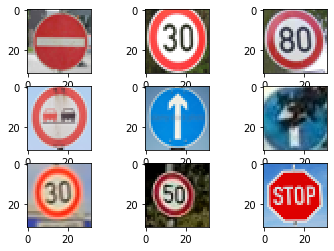

In [15]:
# import modules
import os
import matplotlib.image as mpimg

plt.figure;

# number of new testing images
N = 9
x_test_new = np.zeros((N,32,32,1))

for i in range(N):
    j = i + 1
    image_name = os.path.join("/content/gdrive/My Drive/Datasets/Traffic_Sign/test_images/", str(j) + ".png")
    image = cv2.imread(image_name)
    image_enchanced = grayAndEqualizeHist(image)
    x_test_new[i][:][:][:] = np.array(image_enchanced)[...,np.newaxis]
    
    plt.subplot(3,3,j)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

print('Test images.')

#### Question 6
<i>Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook.</i>

<b>Answer:</b>

I randomly select 9 images (as shown above) from internet and crop/resize them to be 32x32. Some of them are not complete or under shadow.



In [0]:
# 1. test images are already converted from rgb to grayscale
# x_test_new

# 2. add labels for the new testing images
y_test_new = np.array([17,1,5,9,35,35,1,2,14])

# 3. test images are already normalized
# x_test_new = np.array([(img - [128.])/128. for img in x_test_new])

In [17]:
# run the evaluation with the new testing data
architecture = 'ConvNet'

with tf.Session() as sess:    
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./' + architecture +'.meta')
    saver2.restore(sess, "./" + architecture)
    
    test_accuracy = evaluate(x_test_new, y_test_new)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./ConvNet
Test Accuracy = 0.778


#### Question 7
<i>Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate.</i>

> <b>NOTE</b>: <i>You could check the accuracy manually by using signnames.csv (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in signnames.csv and see if it matches the sign from the image.</i>

<b>Answer:</b>

Even though my model perform 95.3% over the test images, my model works poorly (22.2%) with the new collected test images. One of my guesses is that the model overfit to these German Traffic Sign Dataset, so it learns some specific features only for these German Traffic Sign dataset. Another guess is that I didn't balance the number of extra generated testing images for the minority classes. I try to use different models (LeNet and ConvNet) for learning and use different learning parameters, but no good luck with these new images.

INFO:tensorflow:Restoring parameters from ./ConvNet


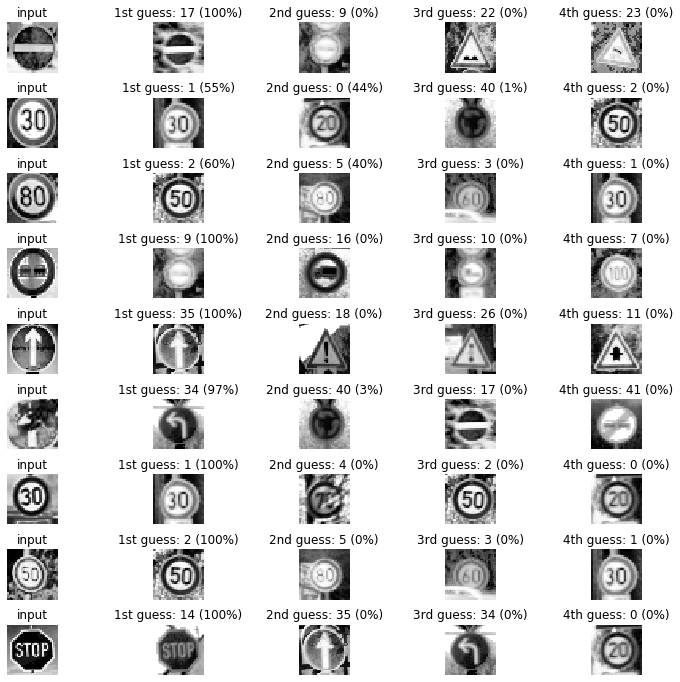

In [18]:
# visualize the softmax probabilities here.
architecture = 'ConvNet'

n = 5
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./' + architecture + '.meta')
    saver.restore(sess, "./" + architecture)
    top_k = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=4), feed_dict={x: x_test_new, keep_prob: 1.0})
    
    fig, axs = plt.subplots(len(x_test_new), n, figsize=(12, 12))
    fig.subplots_adjust(hspace = .5, wspace=.7)
    axs = axs.ravel()

    for i, image in enumerate(x_test_new):

        axs[n*i].axis('off')
        axs[n*i].imshow(image.squeeze(), cmap='gray')
        axs[n*i].set_title('input')
        
        top1 = top_k[1][i][0]
        idx1 = np.argwhere(y_test == top1)[0]
        axs[n*i+1].axis('off')
        axs[n*i+1].imshow(x_test[idx1].squeeze(), cmap='gray')
        axs[n*i+1].set_title('1st guess: {} ({:.0f}%)'.format(top1, 100*top_k[0][i][0]))
        
        top2 = top_k[1][i][1]
        idx2 = np.argwhere(y_test == top2)[0]
        axs[n*i+2].axis('off')
        axs[n*i+2].imshow(x_test[idx2].squeeze(), cmap='gray')
        axs[n*i+2].set_title('2nd guess: {} ({:.0f}%)'.format(top2, 100*top_k[0][i][1]))
        
        top3 = top_k[1][i][2]
        idx3 = np.argwhere(y_test == top3)[0]
        axs[n*i+3].axis('off')
        axs[n*i+3].imshow(x_test[idx3].squeeze(), cmap='gray')
        axs[n*i+3].set_title('3rd guess: {} ({:.0f}%)'.format(top3, 100*top_k[0][i][2]))
        
        top4 = top_k[1][i][3]
        idx4 = np.argwhere(y_test == top4)[0]
        axs[n*i+4].axis('off')
        axs[n*i+4].imshow(x_test[idx4].squeeze(), cmap='gray')
        axs[n*i+4].set_title('4th guess: {} ({:.0f}%)'.format(top4, 100*top_k[0][i][3]))

In [20]:
# method for prediciting the label of an image

image_path = "/content/gdrive/My Drive/Datasets/Traffic_Sign/real_images/9.png"

def predictImageLabel(image_path):
    image = cv2.imread(image_path)
    image_enchanced = grayAndEqualizeHist(image)
    array_image = np.zeros((1,32,32,1))
    array_image[0][:][:][:] = np.array(image_enchanced)[...,np.newaxis]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph('./' + architecture + '.meta')
        saver.restore(sess, "./" + architecture)
        label = sess.run(tf.argmax(logits, 1), feed_dict={x: array_image, keep_prob: 1.0})[0]
    return label

print(predictImageLabel(image_path))

INFO:tensorflow:Restoring parameters from ./ConvNet
14
